### **Specify max. $\tau$.**

In [202]:
tau = 19

In [203]:
print(tau)

19


In [204]:
import numpy as np

#### Stochastic transition matrix for transitions. Exemplified for iid below but applies to every stochastic matrix.

In [205]:
W = np.array([[0.5, 0.7, 0],[0.5, 0, 0.2],[0, 0.3, 0.8]])
# W = np.array([[0.2, 0.7, 0], [0.8, 0, 0.9], [0, 0.3, 0.1]])

W

array([[0.5, 0.7, 0. ],
       [0.5, 0. , 0.2],
       [0. , 0.3, 0.8]])

In [206]:
W.shape

(3, 3)

#### Adjacency matrix for DFA transitions.

In [207]:
A = np.array([[0, 1, -1], [1, -1, 0], [-1, 0, 1]])
A

array([[ 0,  1, -1],
       [ 1, -1,  0],
       [-1,  0,  1]])

### ****Count number of strings, generate strings, get path probabilities associated with strings and DFA trajectories.****

In [208]:
def count_num_str(n):
    return 2**n

num_str = count_num_str(tau)
num_str

524288

In [209]:
def generateStrings(symbols, t):
    strings = []
    n = len(symbols)
    generateStringsRec(symbols, "", n, t, strings)
    return strings
    
def generateStringsRec(symbols, prefix, n, t, strings):
     
    # Base case: t is 0,
    # print prefix
    if (t == 0) :
        strings.append(prefix)
        return
 
    # One by one add all characters
    # from set and recursively
    # call for k equals to k-1
    for i in range(n):
 
        # Next character of input added
        newPrefix = prefix + symbols[i]
         
        # k is decreased, because
        # we have added a new character
        generateStringsRec(symbols, newPrefix, n, t - 1, strings)

In [210]:
symbols = ['0', '1']
idx_state_dict = {0: 'q0', 1: 'q1', 2: 'q2'}
state_idx_dict = {'q0': 0, 'q1': 1, 'q2': 2}

See generated strings.

In [211]:
def generateAllStrings(symbols, t):
    strings = []
    for t in range(tau,tau+1):
        strings.extend(generateStrings(symbols, t))      
    return strings

strings = generateAllStrings(symbols, tau)
# print(strings)

#### Tuple of generated strings, induced DFA trajectories, path probabilities in the forward dynamics. 

In [212]:
def get_path_prob(W, A, strings):
    path_with_prob = []
    for string in strings:
        string_prob, path = compute_prob(W, A, string)
        # normalizing the probability below
        normalized_string_prob = string_prob*(2**len(string))/num_str
        path_with_prob.append((string, normalized_string_prob , path))
        
    return path_with_prob
    
def compute_prob(W, A, string):
    curr_state = 0
    string_prob = 1
    path = []
    for symbol in string:
        path.append(idx_state_dict[curr_state])
        next_state = do_transition(A, curr_state, symbol)
        transition_prob = get_transition_prob(curr_state, next_state, W)
        string_prob *= transition_prob
        curr_state = next_state
    path.append(idx_state_dict[next_state])
    
    return string_prob, path
    
def do_transition(A, curr_state, symbol):
    for j in range(len(A[curr_state])):
        if A[curr_state][j] == int(symbol):
            return j
    
def get_transition_prob(curr_state, next_state, W):
    return W[next_state][curr_state]

# compute path probabilities
path_prob = get_path_prob(W, A, strings)
# path_prob

#### Compute inflow for each DFA state.

In [213]:
# Cell to calculate inflow vector
def calculate_inflow_vector(W):
    return np.sum(W, axis=1)
  
inflow_vector = calculate_inflow_vector(W)
# inflow_vector

In [214]:
# Verify normalization
def verify_normalization(path_prob):
    return [prob[1] for prob in path_prob]

x = verify_normalization(path_prob)
s = 0
for i in x:
    s += i
# s

#### Prepare adjoint dynamics matrix to call soon.

In [215]:
W

array([[0.5, 0.7, 0. ],
       [0.5, 0. , 0.2],
       [0. , 0.3, 0.8]])

In [216]:
def calculate_aux_matrix(W, inflow_vector):
    return np.transpose([W[i]/inflow_vector[i] for i in range(W.shape[0])])

W_aux = calculate_aux_matrix(W, inflow_vector)
W_aux

array([[0.41666667, 0.71428571, 0.        ],
       [0.58333333, 0.        , 0.27272727],
       [0.        , 0.28571429, 0.72727273]])

In [217]:
# calculate prob of sequence in the W_aux matrix
w_aux_path_prob = get_path_prob(W_aux, A, strings)
# path_prob

### Give path probability tuple augmented with accumulated inflow $\epsilon_{\tau}$ associated with each forward path in the forward dynamics.

In [218]:
def append_epsilon_to_path_prob(path_prob, inflow_vector):
    appended_path_prob = []
    for path in path_prob:
        dfa_states = path[2]
        epsilon = 1.0
        for i in range(len(dfa_states)):
            if dfa_states[i] == 'q0' and i > 0: break
            if i == len(dfa_states)-1: continue
            index = list(idx_state_dict.keys())[list(idx_state_dict.values()).index(dfa_states[i])]
            inflow_prob = inflow_vector[index]
            epsilon *= inflow_prob
        path = path + (np.log(epsilon),)
        appended_path_prob.append(path)
    return appended_path_prob

In [219]:
appended_path_prob = append_epsilon_to_path_prob(path_prob, inflow_vector)
# appended_path_prob

In [220]:
def get_path_prob(W, state_sequence):
    prob = 1.0
    for i in range(len(state_sequence)-1):
        prob *= W[state_idx_dict[state_sequence[i+1]]][state_idx_dict[state_sequence[i]]]
    return prob

path_prob_2 = []
for path in appended_path_prob:
    string = path[0]
    seqStates = path[2]
    stoppedSeqStates = []
    for i in range(len(seqStates)):
        stoppedSeqStates.append(seqStates[i])
        if i > 0 and seqStates[i] == 'q0':
            break
    revSeqStates = list(reversed(stoppedSeqStates))
    prob_stopped_seq_states = get_path_prob(W, stoppedSeqStates)
    prob_reverse_seq_states = get_path_prob(W, revSeqStates)
    ratio = prob_stopped_seq_states / prob_reverse_seq_states
    path = path + (np.log(ratio),)
    path_prob_2.append(path)
    
# path_prob_2

In [221]:
# calculate the final step - should be one
sum = 0
for path in path_prob_2:
    delta_s = path[4]
    eps = path[3]
    c = path[1]*(np.exp(-(delta_s + eps)))
    sum += c
sum

0.9999999999997699

In [222]:
W

array([[0.5, 0.7, 0. ],
       [0.5, 0. , 0.2],
       [0. , 0.3, 0.8]])

In [223]:
inflow_vector

array([1.2, 0.7, 1.1])

In [224]:
eps_prob_dict = {}
for p in path_prob_2:
    str_prob = p[1]
    eps = round(p[3], 10)
    if eps in eps_prob_dict:
        eps_prob_dict[eps] += str_prob
    else:
        eps_prob_dict[eps] = str_prob
# print(eps_prob_dict)

In [225]:
ef_prob_dict = {}
for p in path_prob_2:
    str_prob = p[1]
    ent_flow = round(p[4], 10)
    if ent_flow in ef_prob_dict:
        ef_prob_dict[ent_flow] += str_prob
    else:
        ef_prob_dict[ent_flow] = str_prob
print(ef_prob_dict)

{0.0: 0.9842770534342928, -0.3364722366: 0.002941503290303231, 0.0689928715: 0.012781443275811846}


In [226]:
ef_eps_prob_dict = {}
for p in path_prob_2:
    str_prob = p[1]
    flow = np.exp(-(p[4]+p[3]))
    if flow in ef_eps_prob_dict:
        ef_eps_prob_dict[flow] += str_prob
    else:
        ef_eps_prob_dict[flow] = str_prob
# print(ef_eps_prob_dict)

In [227]:
# to confirm probabilities = 1
np.array(list(ef_eps_prob_dict.values())).sum()

0.9999999999996243

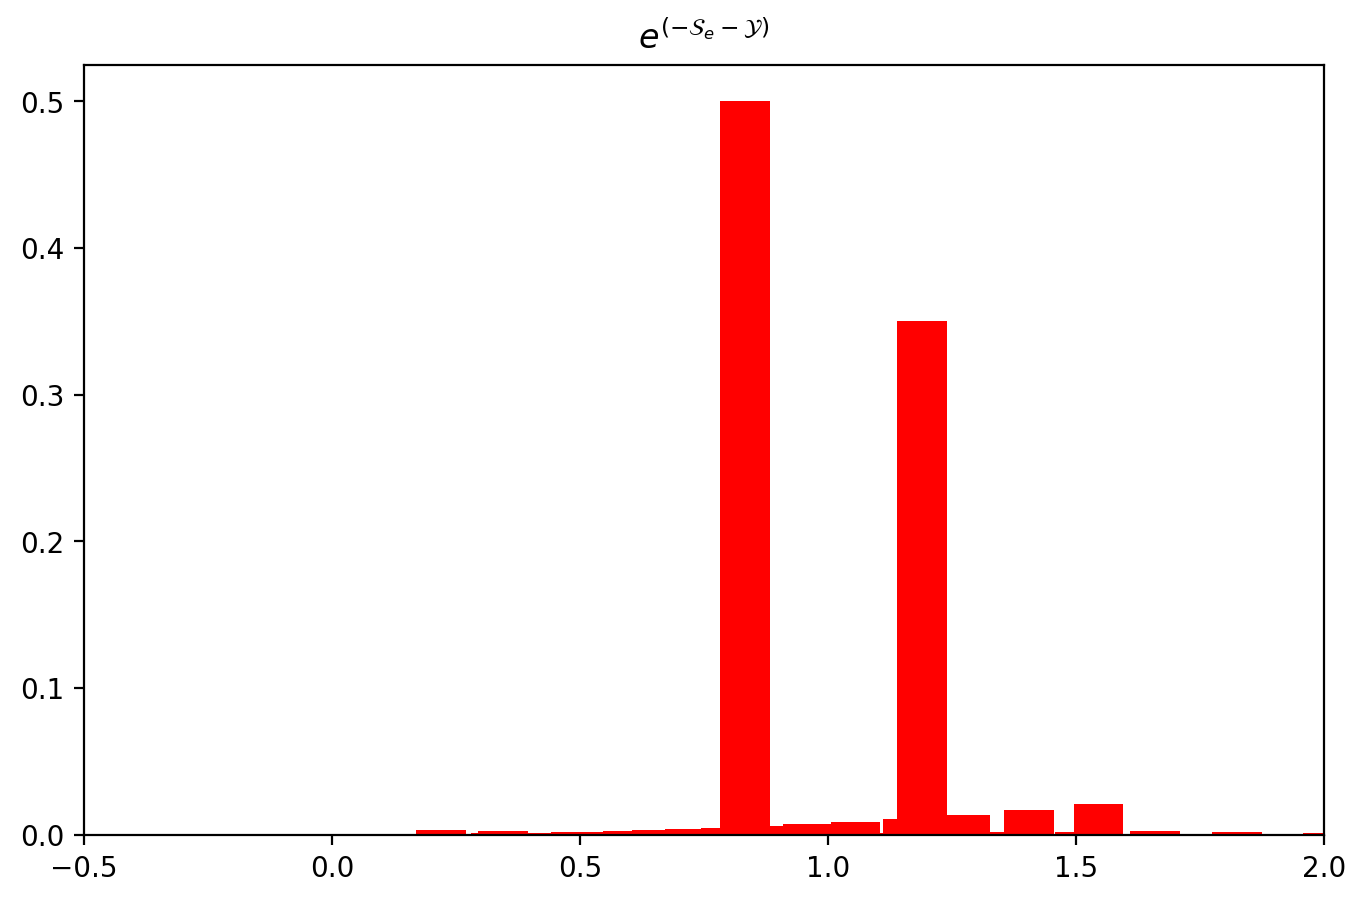

In [242]:
# to plot the histograms
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5), dpi=200)
plt.title('$e^{(-\mathcal{S}_e-\mathcal{Y})}$')
plt.bar(ef_eps_prob_dict.keys(), ef_eps_prob_dict.values(), .1, color='r')
# print(max_key)
plt.xlim([-0.5, 2])
plt.show()

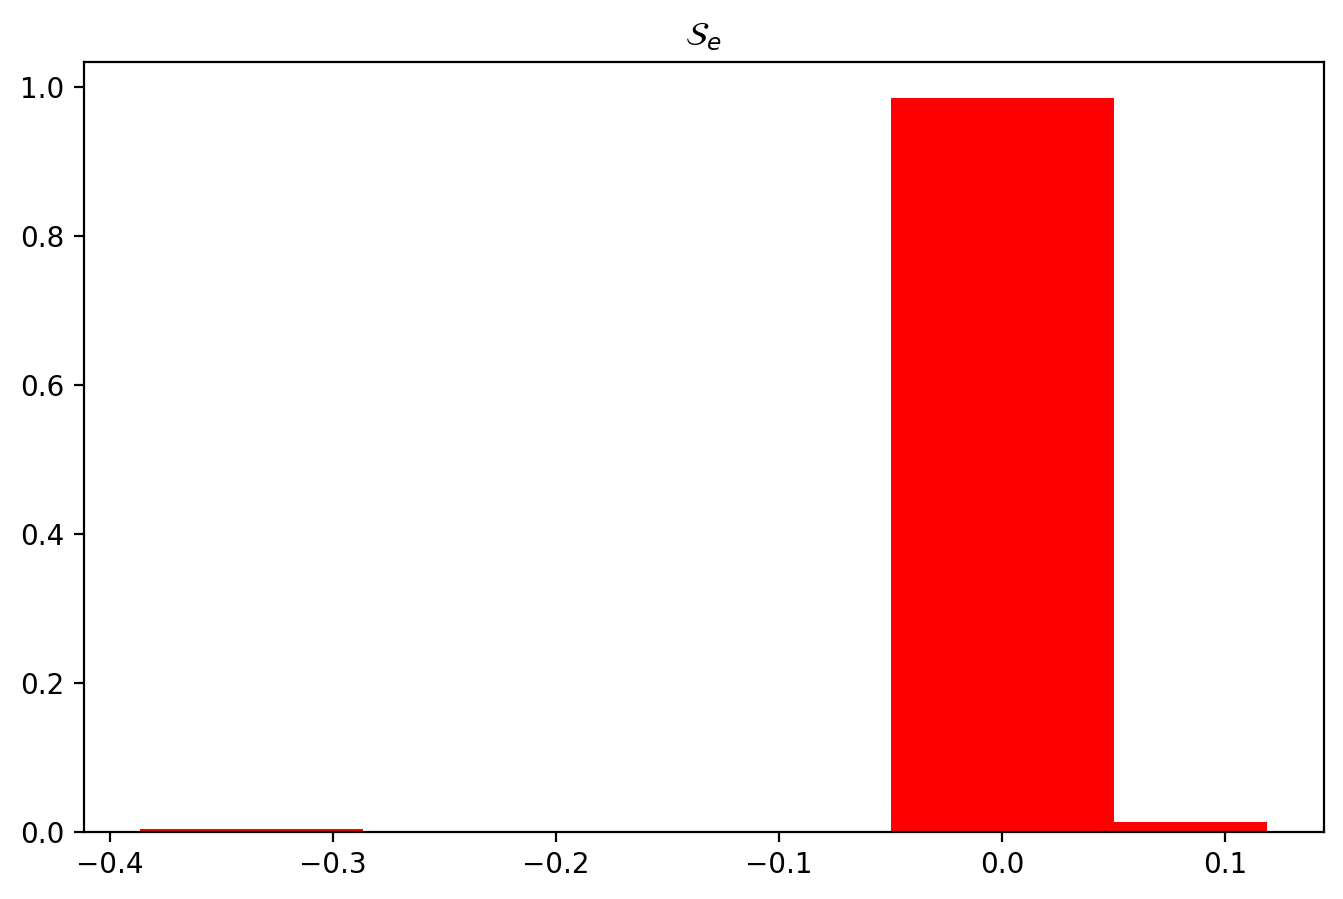

In [243]:
plt.figure(figsize=(8, 5), dpi=200)
plt.bar(ef_prob_dict.keys(), ef_prob_dict.values(), .1, color='r')
plt.title('$\mathcal{S}_e$')

# print(max_key)
# plt.xlim([-0.1, 2])
plt.title('$\mathcal{S}_e$')
plt.show()

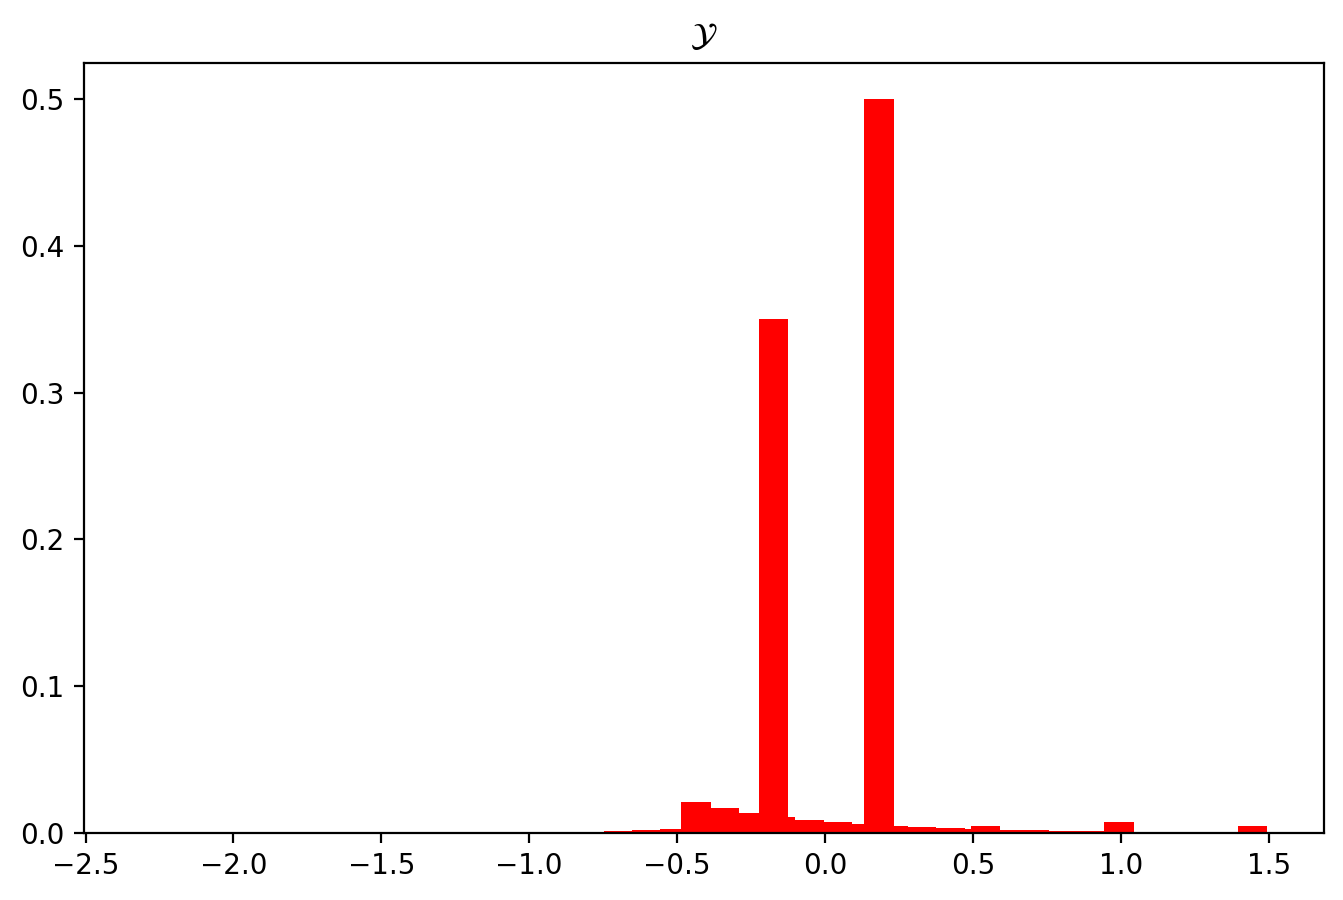

In [244]:
# to plot the histograms

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5), dpi=200)

plt.bar(eps_prob_dict.keys(), eps_prob_dict.values(), .1, color='r')
plt.title('$\mathcal{Y}$')

# print(max_key)
# plt.xlim([-0.5, 2])
plt.show()